# Word Vectors

### **Nombre:** Kevin Fabricio Calle Urgilez

### **Asignatura:** Sistemas Cognitivos Artificiales 

### **Fecha:** 19/11/18

En este trabajo, utilizaremos **embeddings** para resolver un problema de clasificación de texto. Los embeddings, representaciones distribuidas y vectoriales de elementos, son un concepto muy común en el mundo del deep learning. Los **word vectors** que hemos visto en clase son una representación en forma de embedding de las palabras.

Para realizar este trabajo y sacarle el máximo partido, se recomienda ver los siguientes vídeos de clase:

*   Clasificación de texto con Word Vectors.
*   Análisis de overfitting con un modelo bag of words.
*   Clasificación de texto con RNN

Vamos a utilizar el dataset **"Reuters newswire topics classification"**, disponible desde Keras de manera similar al dataset de IMDB ([ver documentación](https://keras.io/datasets/#reuters-newswire-topics-classification)).

---

Se pide:

Entrenar un modelo **utilizando embeddings** que consiga un **65% de accuracy en test (55% si usamos RNNs)**, mostrando el entrenamiento y el resultado final.
 
Tenemos varias opciones para entrenar modelos con embeddings. El alumno puede explorar más de una pero es suficiente con conseguir un modelo que alcance la accuracy requerida:

*   Utilizar una **media de embeddings** al estilo de lo visto en el vídeo *Clasificación de texto con Word Vectors*
*   Utilizar una **CNN** sobre una secuencia de word vectors. Aquí necesitamos cambiar un poco la idea de convolución para actuar sobre sequencias de vectores. Keras incluye una [Convolución en 1D](https://keras.io/layers/convolutional/#conv1d) que puede ser utilizada en este caso, con un ejemplo de uso en la documentación. Una forma de hacer funcionar este esquema sería utilizar la convolución en 1D + max pooling.
*  Utilizar una **RNN** sobre una secuencia de word vectors, al estilo de lo visto en el vídeo *Clasificación de texto con RNN*. Para este problema es un poco complicado conseguir un buen modelo con RNNs, y además es más difícil experimentar ya que las redes recurrentes son modelos lentos de entrenar. Por eso, es suficiente con alcanzar un 55% de accuracy si optamos por utilizar un modelo de este estilo. Un buen consejo es emplear una red recurrente bidireccional como se ve en el vídeo *Clasificación de texto con RNN*.



---

Dos hiperparámetros importantes a elegir en el modelo son la **longitud de las secuencias de texto** y el **tamaño del vocabulario** para los embeddings. Podéis experimentar con ambos, o utilizar los mismos que se usan en los vídeos. Nótese que, al cortar todas las secuencias para que tengan el mismo tamaño, podríamos estar perdiendo mucho texto si elegimos un tamaño de secuencia demasiado pequeño. Igualmente, si las hacemos muy largas necesitaremos más tiempo para entrenar nuestros modelos. Una buena idea consiste en explorar los datos para ver cómo suelen ser de largos los textos y encontrar un buen trade-off para el tamaño de al secuencia.



---

Los embeddings que hemos visto en los vídeos se entrenan junto al modelo.  Una técnica frecuente es inicializar estos embeddings con word-vectors pre-entrenados en un gran corpus de texto, como hemos visto en clase. Esto puede ayudar ya que nuestro modelo empieza con unos embeddings que ya encapsulan significado. Si bien no es necesario para esta práctica, podéis ver cómo usar esta técnica [en el siguiente tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

In [1]:
# Se importan las librerías necesarias

import keras
from keras.datasets import reuters
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling1D, BatchNormalization

Using TensorFlow backend.


## 1. Descripción de los datos

* [Reuters newswire topics classification](https://keras.io/datasets/#reuters-newswire-topics-classification)


El dataset se forma de 11,228 noticias de Reuters, con más de 46 temas.
Las noticias han sido preprocesadas y cada revisión se codifica como una secuencia de índices de palabras (enteros). Los índices representan la frecuencia con la aparecen las palabras en los datos completos.

In [0]:
# Se descargan los datos de "Reuters newswire topics classification" y se los separa en conjuntos de train y test. 
# El parámetro num_words permite elegir, en este caso, las 10000 palabras más frecuentes.

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

In [3]:
# Se imprime en pantalla el tamaño del set de entrenamento, test y el número de clases.

print('Número de datos en el conjunto de entrenamiento: {}'.format(len(x_train)))
print('Número de datos en el conjunto de test: {}'.format(len(x_test)))

num_classes = max(y_train) + 1
print('Número de clases: {}'.format(num_classes))

Número de datos en el conjunto de entrenamiento: 8982
Número de datos en el conjunto de test: 2246
Número de clases: 46


In [4]:
# Se imprime una muestra de entrenamiento. Esta se representa por sus índices

print(x_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [0]:
# Se obtiene el índice de las palabras con la función .get_word_index()

word_index = reuters.get_word_index(path="reuters_word_index.json")

# Función que convierte los índices en palabras

index_to_word = {}
for key, value in word_index.items():
    index_to_word[value] = key

In [6]:
# Se imprime en pantalla la conversión de índices a palabras para una de las muestras

print(' '.join([index_to_word[x] for x in x_train[0]]))
print(y_train[0])

the of of mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs
3


## 2. Preparación de los datos

Se tokenizan los datos para representarlos de manera binaria. Es decir, si una palabra del vocabulario está presente en el párrafo esta se muestra como 1, caso contrario si la palabra es desconocida según el vocabulario esta se representa como 0.

In [0]:
# Se tokenizan las muestras para representarlas de manera binaria.

# Se define que nuestro vocabulario consta de 10000 palabras

vocabulario = 10000

tokenizer = Tokenizer(num_words = vocabulario)

x_train = tokenizer.sequences_to_matrix(x_train, mode = 'binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode = 'binary')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
# Se imprime una muestra del conjunto de train tokenizado

print(x_train[0])

# Se imprime el tamaño del vector tokenizado

print(len(x_train[0]))

[0. 1. 1. ... 0. 0. 0.]
10000


In [9]:
# Se imprime una muestra del conjunto de test tokenizado

print(y_train[0])

# Se imprime el tamaño del vector tokenizado

print(len(y_train[0]))

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
46


## 3. Red Neuronal

#### 3.1 Topología de la Red neuronal

Se crea una red neuronal utilizando embeddings. 
- La entrada de la red son los conjuntos de train de tamaño del vocabulario representados de manera binaria. 1 si la palabra existe y 0 si no existe.
- Tenemos una capa intermedia de 512 neuronas con activación Relu.
- Tenemos 1 capa de regularización Dropout para evitar el sobre ajuste de datos
- Aplicamos una capa de average pooling para obtener un promedio de reducido de los datos de la capa anterior.
- Tenemos una capa de salida con 46 neuronas (una por cada clase) con función de activación tipo softmax para representar las predicciones como
densidades de probabilidad.

In [10]:
# Creamos la red neuronal

model = Sequential()
model.add(keras.layers.Embedding(vocabulario, 64, input_length = 10000))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(AveragePooling1D())
model.add(Flatten())
model.add(Dense(46, activation='softmax'))

# Vemos el resumen de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10000, 64)         640000    
_________________________________________________________________
dense_1 (Dense)              (None, 10000, 512)        33280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000, 512)        0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 5000, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                117760046 
Total params: 118,433,326
Trainable params: 118,433,326
Non-trainable params: 0
______________________________________________________________

In [0]:
# Se establecen los parámetros de la red neuronal. Compilamos el modelo y establecemos las métricas
# de evaluación y el optimizador

batch_size = 32
epochs = 4

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 3.2 Entrenamiento de la red neuronal

Modelos con embeddings generan gran cantidad de parámetros en la red por lo que fue necesario utilizar capas de average_pooling y procesamiento con GPU para optimizar el cómputo.

In [12]:
# Entrenamos la red neuronal

history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 7185 samples, validate on 1797 samples
Epoch 1/4
7185/7185 [==============================] - 176s 24ms/step - loss: 1.5523 - acc: 0.6866 - val_loss: 1.0880 - val_acc: 0.7885
Epoch 2/4
7185/7185 [==============================] - 170s 24ms/step - loss: 0.5037 - acc: 0.8939 - val_loss: 1.1551 - val_acc: 0.7869
Epoch 3/4
7185/7185 [==============================] - 169s 24ms/step - loss: 0.2999 - acc: 0.9379 - val_loss: 1.3068 - val_acc: 0.7713
Epoch 4/4
7185/7185 [==============================] - 170s 24ms/step - loss: 0.2564 - acc: 0.9486 - val_loss: 1.3509 - val_acc: 0.7752


## 4. Evaluación del modelo

#### 4.1 Funciones para evaluaciones del modelo

In [0]:
# Funciones para realizar gráficos de la precisión y pérdidas en el modelo

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

#### 4.2 Precisión del modelo 

Podemos observar en el siguiente gráfico la precisión para los conjuntos de train y validation. El modelos se entrena correctamente en 1 época. A partir de la época 2 se cae en sobreajuste.
Esto puede pasar porque la cantidad de datos es pequeña para la potencia del modelo. 

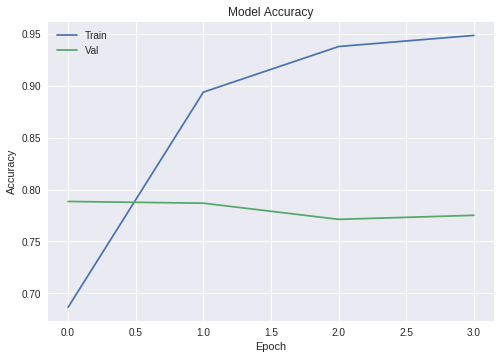

In [14]:
plot_acc(history)

#### 4.3 Pérdidas del modelo

De igual forma se observa que en la época 1 el error alcanza su nivel mínimo. A partir de la época 2 el error incrementa.

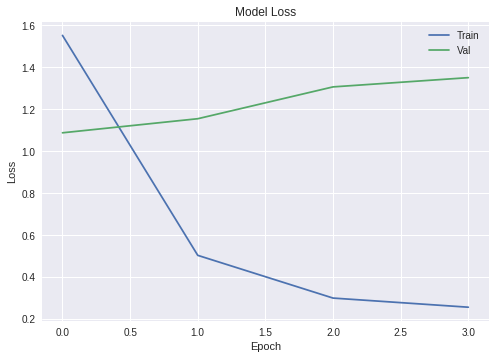

In [15]:
plot_loss(history)

#### 4.4 Evaluación del modelo con datos de TEST

In [16]:
# Se evalúa la precisión y las pérdidas del modelo con datos de test

score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test accuracy:', score[1])
print('Test loss:', score[0])

2246/2246 [==============================] - 5s 2ms/step
Test accuracy: 0.7560106857164779
Test loss: 1.4107788742809346
